# 🧪 Exploratory Data Analysis: Metabolomic Signatures in Type 2 Diabetes (T2D)

This notebook presents a comprehensive **exploratory data analysis (EDA)** of a metabolomics dataset focused on **Type 2 Diabetes (T2D)**. The aim is to uncover patterns, correlations, and biologically meaningful relationships between various metabolites and disease status. The analysis is intended as a foundational step toward building predictive models and gaining biological insight into T2D.

---

## 📌 Key Components

- **🔢 Dataset Overview**: Summary of data structure, sample size, feature distribution, and initial cleaning steps.
- **📊 Correlation Analysis**: Spearman correlations between metabolites, highlighting those with |r| ≥ 0.4.
- **🧬 Biological Interpretation**: Annotated interpretation of top metabolite correlations, with potential mechanistic links to insulin resistance, glycemic control, lipid metabolism, and gut microbial activity.
- **📈 Feature Relevance for Modeling**: Findings help identify biologically relevant and statistically significant features for downstream machine learning or statistical modeling.

---

## 📁 Dataset Details

The dataset consists of metabolite concentration measurements from a cohort of individuals classified by T2D disease status. Each feature represents a metabolite measured using high-throughput mass spectrometry. The dataset may include missing values, outliers, and varying data scales, all of which are handled during preprocessing.

---

## 🧭 Methodological Approach

- Data inspection and validation
- Correlation heatmap and feature-level analysis
- Manual annotation of top correlations
- Preliminary statistical testing for group-level differences (e.g., Mann–Whitney U test)
- Optional SHAP-based feature interpretability (if modeling is extended)

---

## 🎯 Objective

To identify metabolomic features that differ meaningfully between individuals with and without T2D, and to generate hypotheses for future biomarker discovery or predictive modeling.

---

## 🧾 Credits and Funding (if applicable)

*This analysis is part of an independent research exploration into metabolomic signatures of Type 2 Diabetes. Please cite the original data source or publication if reusing the data.*

Source: https://www.metabolomicsworkbench.org/

---

*Author: [Tomasz Lasota]*  
*Date: [2025-06-29]*


## Part 1: Exploratory Data Analysis

## 1. Settings and Imports

In [186]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
import math
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
from scipy.stats import norm
from statsmodels.stats.multitest import multipletests
from sklearn.impute import SimpleImputer
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities
from itertools import product
from tabulate import tabulate
from statannotations.Annotator import Annotator

In [129]:
# Define class for handling notebook and dataset imports and settings
class CF:

    def __init__(self):
        self.dataset = Path("ST001906_1.txt")

        if not self.dataset.exists():
            raise FileNotFoundError(f"Dataset {self.dataset} not found.")

## 2. Data Exploration

In [130]:
# load dataset skipping the first and last 3 rows
df = pd.read_csv(
    CF().dataset, sep="\t", header=0, skiprows=1, skipfooter=3, engine="python"
)

In [131]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 63 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Metabolite_name  79 non-null     object
 1   RefMet_name      79 non-null     object
 2   C01              79 non-null     object
 3   C02              79 non-null     object
 4   C03              79 non-null     object
 5   C04              77 non-null     object
 6   C05              79 non-null     object
 7   C06              79 non-null     object
 8   C07              79 non-null     object
 9   C08              79 non-null     object
 10  C09              79 non-null     object
 11  C10              79 non-null     object
 12  C11              78 non-null     object
 13  C12              79 non-null     object
 14  C13              78 non-null     object
 15  C14              79 non-null     object
 16  C15              78 non-null     object
 17  C16              78 non-null     obje

In [132]:
# test for duplicates
df.duplicated().sum()

np.int64(0)

In [133]:
df.head()

,Metabolite_name,RefMet_name,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,P01B,P02B,P03B,P04B,P05B,P06B,P07B,P08B,P09B,P10B,P11B,P12B,P13B,P14B,P15B,P16B,P17B,P19B,P20B,P21B,P22B,P23B,P24B,P25B,P26B,P27B,P29B,P30B,P31B,P32B,P33B
0,Factors,-,Diagnosis:Control,Diagnosis:Control,Diagnosis:Control,Diagnosis:Control,Diagnosis:Control,Diagnosis:Control,Diagnosis:Control,Diagnosis:Control,Diagnosis:Control,Diagnosis:Control,Diagnosis:Control,Diagnosis:Control,Diagnosis:Control,Diagnosis:Control,Diagnosis:Control,Diagnosis:Control,Diagnosis:Control,Diagnosis:Control,Diagnosis:Control,Diagnosis:Control,Diagnosis:Control,Diagnosis:Control,Diagnosis:Control,Diagnosis:Control,Diagnosis:Control,Diagnosis:Control,Diagnosis:Control,Diagnosis:Control,Diagnosis:Control,Diagnosis:Control,Diagnosis:Diabetes,Diagnosis:Diabetes,Diagnosis:Diabetes,Diagnosis:Diabetes,Diagnosis:Diabetes,Diagnosis:Diabetes,Diagnosis:Diabetes,Diagnosis:Diabetes,Diagnosis:Diabetes,Diagnosis:Diabetes,Diagnosis:Diabetes,Diagnosis:Diabetes,Diagnosis:Diabetes,Diagnosis:Diabetes,Diagnosis:Diabetes,Diagnosis:Diabetes,Diagnosis:Diabetes,Diagnosis:Diabetes,Diagnosis:Diabetes,Diagnosis:Diabetes,Diagnosis:Diabetes,Diagnosis:Diabetes,Diagnosis:Diabetes,Diagnosis:Diabetes,Diagnosis:Diabetes,Diagnosis:Diabetes,Diagnosis:Diabetes,Diagnosis:Diabetes,Diagnosis:Diabetes,Diagnosis:Diabetes,Diagnosis:Diabetes
1,1_5-Anhydroglucitol,"1,5-Anhydrosorbitol",76134.0679,68229.8179,75060.0460,21889.5860,61684.2890,115496.8453,77569.5444,87619.4513,89593.7052,73924.5586,84214.0785,77207.2624,73514.4942,56598.0364,47985.1288,84646.8484,58780.0438,41762.8076,30987.2098,71367.7254,70983.4450,104808.7031,40677.6118,63286.9820,101213.7829,36735.7648,84648.7275,52211.8086,46457.4296,86133.2959,13253.6358,23742.9413,19126.7437,3998.8018,1429.5810,7922.7122,17150.0611,1030.0832,3820.5955,26584.1804,11871.8831,11889.1196,16220.2392,55929.1581,3327.7050,33607.8443,10562.1677,53322.0152,2804.0378,4195.8929,11696.0818,1366.5750,4011.0743,1485.9307,4361.8853,23685.9709,13167.1581,42091.9933,2360.8300,889.5784,5389.3421
2,2-Aminobutyrate,2-Aminobutyric acid,2483.6464,1171.0519,1812.2221,982.1933,1525.7878,1090.4060,1269.0313,1786.2425,1715.1659,2032.1477,864.0777,1608.2349,1603.1380,2695.7062,2631.7000,1923.0140,2004.6430,3144.2586,1978.6550,970.6215,1426.0807,526.6212,580.3341,647.9221,1372.7115,1986.2204,1488.8458,1947.9634,2282.2523,1608.0875,2677.8994,1440.2350,2702.8365,2356.4047,2424.8741,1674.6177,2540.6941,4397.5563,2401.9654,3263.8548,1592.3699,2907.3792,2685.8709,2891.0708,2709.0007,1901.7740,2232.5848,1800.5092,1457.7648,2859.2901,2381.8568,2203.0673,3151.7086,2574.6249,3184.0889,2672.3013,2889.2573,2284.7122,3026.2174,3586.0458,3237.7158
3,2-Hydroxybutyrate,2-Hydroxybutyric acid,4785.6271,4043.5030,3822.1668,4140.3742,6823.5424,9683.3429,6729.0747,6613.6143,8209.6409,6207.8405,6480.3312,6721.7052,5024.2018,7467.5258,9079.7784,6466.0489,5994.2317,10004.3141,10554.6912,7198.1733,5084.0233,5746.3738,5974.9351,7713.9197,7202.4133,8774.9916,5483.9208,6860.4574,9329.9265,5772.0889,12791.6791,9673.1266,16279.2398,21577.8779,28975.8230,9149.9475,10953.8474,21485.1470,10500.2434,10278.5010,10362.5456,13391.3676,8661.7870,17348.4848,20126.1328,10060.6887,12897.5900,16055.0466,15087.3892,15542.1596,10011.5089,14332.5561,16349.3766,16522.0347,21152.4515,15942.5127,15007.9743,10137.0140,17545.8158,8798.9741,22780.4208
4,3-Aminoisobutyrate,3-Aminoisobutanoic acid,3170.5029,3031.3133,3015.3690,3579.3690,2776.2411,4072.6505,3019.2438,2940.5403,2531.2441,3001.9429,3189.6743,3030.3229,3117.8871,3526.4712,2594.4535,2327.5955,2124.9175,3169.4147,2308.4909,1980.9805,3094.9405,3669.2839,2952.7935,3150.5223,2392.9081,2959.0028,3367.3315,3165.5119,2493.2105,2914.3291,4649.0717,7219.2062,3062.3823,4040.4823,3249.7733,3168.1100,3459.7026,3783.3806,3198.9111,4634.4593,3803.5393,3647.6828,2338.0963,2977.4706,3462.2962,2578.2318,2869.8034,4504.8007,2679.

In [134]:
# Drop one of the columns with the metabolite names
df.drop(columns=["RefMet_name"], inplace=True)

In [135]:
# Transpose the dataframe to have metabolites as columns
# rename the approprite columns containung the class labels and sample IDs
df = df.T
df.columns = df.iloc[0]  # use the first row as the column names
df = df.iloc[1:]  # drop the first row
df.reset_index(inplace=True)

df.rename(
    columns={
        "index": "ID",
        "Factors": "Class",
        "1_5-Anhydroglucitol": "1,5-Anhydroglucitol",
    },
    inplace=True,
)

df.columns.name = None  # remove the name of the index column

In [136]:
df.head()

,ID,Class,"1,5-Anhydroglucitol",2-Aminobutyrate,2-Hydroxybutyrate,3-Aminoisobutyrate,3-Hydroxybutyrate,Alanine,Allose,alpha-Tocopherol,Arabinose,Arginine,Asparagine,Aspartate,beta-Alanine,Cholesterol,Citrate,Creatinine,Cysteine,Cystine,Elaidiate,Erythritol,Ethanolamine,Fructose,Galactose,Gluconate,Glucose,Glucuronate,Glutamate,Glutamine,Glycerate,Glycine,Glycolate,Heptadecanoate,Hippurate,Histidine,Hydroxyproline,Hypotaurine,Indole-3-acetaldehyde,Inositol,Isoleucine,Ketoisoleucine,Ketovaline,Lactate,Laureate,Leucine,Linoleate,Lysine,Malate,Mannitol,Mannose,Methionine,Myristate,N-Acetylglucosamine,Oleate,Ornithine,Palmitate,Palmitoleate,Paraxanthine,Pentadecanoate,Phenylalanine,Phosphate,Proline,Propylene glycol,Pyroglutamate,Pyruvate,Quinate,Serine,Spermidine,Stearate,Succinate,Threonate,Threonine,Tryptophan,Tyrosine,Urate,Urea,Uridine,Valine,Xylulose
0,C01,Diagnosis:Control,76134.0679,2483.6464,4785.6271,3170.5029,78663.0271,325359.7759,13080.7146,17004.6243,858.2481,1685.5882,3666.4185,1180.9436,3771.9719,15864.6296,6985.3963,1225.3336,4920.5111,1919.5189,2522.7441,3175.7418,3858.9592,1214.4917,634825.5461,676.1394,4149219.6750,2019.7692,7748.5325,61994.7450,2065.3815,290689.6347,3210.2793,2846.5792,2338.4698,60404.1140,4675.9283,854.3500,28360.3631,29036.9932,27473.5989,1447.7721,376.5133,298409.9083,9907.9399,208834.8588,8016.9693,29596.1507,270.9576,779.0897,38600.7928,15496.8211,3783.0921,514.6571,18303.8202,48468.8931,152908.1729,577.8978,795.6987,1681.6169,47605.2642,532144.4178,207510.4735,23.2163,11943.9946,2439.8644,1681.3055,71825.8606,497.7437,99017.4080,2298.1521,5507.2429,53797.8621,196307.0489,132745.3571,227581.6297,2500712.2060,2388.3416,402362.8160,902.2380
1,C02,Diagnosis:Control,68229.8179,1171.0519,4043.5030,3031.3133,17390.0075,323430.1298,12230.4685,21773.9858,510.7749,1687.9871,5653.7235,738.2649,2424.6790,23862.4950,10431.9672,1951.1722,5663.1689,2136.7857,2444.9798,1538.7594,3983.7933,400.0520,800508.1925,1059.3181,4721462.2720,2107.5272,4163.8439,78848.8809,1982.7272,253276.3921,3410.6157,2991.3648,163.0516,82956.2598,7400.5792,1304.9198,29801.3080,33574.4540,24121.4111,863.7654,334.5314,382862.3587,5752.9561,241592.1730,8831.5161,31377.0038,385.0264,912.7569,31547.0663,17884.7249,6666.0763,565.7983,18630.1952,36200.7215,186914.8184,3087.5777,3142.4462,1359.8399,74403.8513,556898.4097,173623.4135,106.2943,13128.1631,11141.4671,3147.0201,84376.1597,290.3477,107156.9112,2287.1496,2123.0647,50510.9227,261875.3204,182488.5616,144834.5131,2728527.7610,2229.2537,463447.9622,492.9723
2,C03,Diagnosis:Control,75060.0460,1812.2221,3822.1668,3015.3690,17036.9851,257628.0056,9330.0788,14931.4521,285.3248,1324.8510,3213.9945,1145.4658,2082.4192,19519.6829,8901.5014,1053.9706,4337.8970,1447.0840,1500.2304,3066.2747,3407.2720,2210.8444,604565.9701,721.6494,3899320.5700,2316.1652,3561.4293,62091.8213,2067.9550,246435.9798,5060.6284,1987.4360,1580.0953,64794.8406,13915.9487,711.9306,28154.9128,31404.5602,21493.5598,993.3147,314.8218,255943.8568,6385.2866,170412.7357,7633.3300,24274.5246,585.7716,7187.4356,29470.3707,13391.0377,4545.3208,806.7754,9210.8860,27004.5378,145240.2558,1501.5763,1581.4519,2753.0235,54974.4104,495827.7953,145152.0983,79.8435,11025.5930,6166.1271,961.3177,69637.5849,732.5512,76992.7452,2829.0987,3339.2427,41762.9209,226547.3473,118124.2550,231965.0438,2489866.2910,1478.4680,352389.1496,877.0040
3,C04,Diagnosis:Control,21889.5860,982.1933,4140.3742,3579.3690,14830.6049,480618.6042,9259.4009,13318.2075,116.8756,2055.3927,4603.5890,1277.6008,1378.7001,15039.7917,7860.4778,1094.3761,3895.3856,1219.1907,1422.5349,1984.2783,3082.7674,487.9637,608420.0851,779.0159,4013778.9180,3211.6073,8230.9131,74852.4886,2096.6408,297346.8295,3835.6930,2313.8479,NaN,76083.7382,7708.5860,583.0590,25954.2911,27116.4700,18068.1337,606.8237,140.8749,376792.6146,7472.4039,148663.0606,6456.0667,28912.3984,409.8200,2811.0022,19903.8757,14975.0326,5217.5450,959.6441,10615.1490,35559.2186,122456.2077,1474.0485,225.8381,29

In [137]:
# convert the class labels to 0 and 1
df["Class"] = df["Class"].map({"Diagnosis:Control": 0, "Diagnosis:Diabetes": 1})
# convert the data objects into numbers where possible
for col in df.columns:
    try:
        df[col] = pd.to_numeric(df[col])
    except Exception:
        print(f"Column {col} could not be converted to numeric")

Column ID could not be converted to numeric


In [138]:
def missing_values_summary(df: pd.DataFrame = None):
    if df is not None:
        missing_values = df.isnull().sum()
        missing_percentage = (missing_values / len(df)) * 100
        missing_data = pd.DataFrame(
            {"Missing Values": missing_values, "Percentage": missing_percentage}
        )

        # Filter columns with missing values
        missing_data = missing_data[missing_data["Missing Values"] > 0]
        # Sort by the number of missing values for better readability
        missing_data = missing_data.sort_values(by="Missing Values", ascending=False)
        missing_data_transposed = missing_data.transpose()

        # Adjust display options for better visibility
        pd.set_option("display.float_format", "{:.2f}".format)
        pd.set_option("display.max_columns", None)  # Show all columns
        pd.set_option("display.width", 1000)  # Increase width for wide tables
        # Display the missing data summary in a professional format using tabulate
        print("🔍 Missing Values Summary:")
        print(tabulate(missing_data_transposed, headers="keys", tablefmt="pretty"))


def get_info(df: pd.DataFrame = None, type: str = "percent") -> pd.DataFrame:

    if type.lower() == "percent":
        value = (df.count().values / len(df) * 100).round(3)
        unit = "%"
    elif type.lower() == "count":
        value = df.count().values
        unit = "Count"
    else:
        print("Invalid type argument")

    df_info = pd.DataFrame(
        {
            "Column Names": df.columns,
            f"Non-null values ({unit})": value,
            "Data Type": df.dtypes.values,
        }
    )

    return df_info

In [139]:
print(tabulate(get_info(df), headers="keys", tablefmt="pretty"))

+----+-----------------------+---------------------+-----------+
|    |     Column Names      | Non-null values (%) | Data Type |
+----+-----------------------+---------------------+-----------+
| 0  |          ID           |        100.0        |  object   |
| 1  |         Class         |        100.0        |   int64   |
| 2  |  1,5-Anhydroglucitol  |        100.0        |  float64  |
| 3  |    2-Aminobutyrate    |        100.0        |  float64  |
| 4  |   2-Hydroxybutyrate   |        100.0        |  float64  |
| 5  |  3-Aminoisobutyrate   |        100.0        |  float64  |
| 6  |   3-Hydroxybutyrate   |        100.0        |  float64  |
| 7  |        Alanine        |        100.0        |  float64  |
| 8  |        Allose         |       98.361        |  float64  |
| 9  |   alpha-Tocopherol    |        100.0        |  float64  |
| 10 |       Arabinose       |        100.0        |  float64  |
| 11 |       Arginine        |        100.0        |  float64  |
| 12 |      Asparagine   

In [140]:
# Basic descriptive statistics
df.describe()

,Class,"1,5-Anhydroglucitol",2-Aminobutyrate,2-Hydroxybutyrate,3-Aminoisobutyrate,3-Hydroxybutyrate,Alanine,Allose,alpha-Tocopherol,Arabinose,Arginine,Asparagine,Aspartate,beta-Alanine,Cholesterol,Citrate,Creatinine,Cysteine,Cystine,Elaidiate,Erythritol,Ethanolamine,Fructose,Galactose,Gluconate,Glucose,Glucuronate,Glutamate,Glutamine,Glycerate,Glycine,Glycolate,Heptadecanoate,Hippurate,Histidine,Hydroxyproline,Hypotaurine,Indole-3-acetaldehyde,Inositol,Isoleucine,Ketoisoleucine,Ketovaline,Lactate,Laureate,Leucine,Linoleate,Lysine,Malate,Mannitol,Mannose,Methionine,Myristate,N-Acetylglucosamine,Oleate,Ornithine,Palmitate,Palmitoleate,Paraxanthine,Pentadecanoate,Phenylalanine,Phosphate,Proline,Propylene glycol,Pyroglutamate,Pyruvate,Quinate,Serine,Spermidine,Stearate,Succinate,Threonate,Threonine,Tryptophan,Tyrosine,Urate,Urea,Uridine,Valine,Xylulose
count,61.00,61.00,61.00,61.00,61.00,61.00,61.00,60.00,61.00,61.00,61.00,61.00,61.00,61.00,61.00,61.00,61.00,61.00,61.00,61.00,61.00,61.00,61.00,61.00,61.00,61.00,61.00,61.00,61.00,61.00,61.00,61.00,60.00,49.00,61.00,61.00,61.00,61.00,61.00,61.00,61.00,61.00,61.00,61.00,61.00,61.00,61.00,61.00,61.00,61.00,61.00,61.00,61.00,61.00,61.00,61.00,61.00,61.00,61.00,61.00,61.00,61.00,61.00,61.00,61.00,55.00,61.00,61.00,61.00,61.00,61.00,61.00,61.00,61.00,61.00,61.00,61.00,61.00,61.00
mean,0.51,40880.64,2119.17,10881.51,3357.06,76975.55,392346.95,14720.40,15928.66,508.82,1737.96,4116.70,1324.85,1983.81,15198.01,10187.38,1127.83,4413.39,2323.89,2451.79,6535.70,3088.51,2051.56,899676.29,1523.06,5227384.07,2080.77,12758.33,62304.80,2227.37,242191.95,3587.18,2692.37,1057.92,66897.89,7105.91,1018.07,34862.37,29038.83,21720.07,1232.31,419.33,379333.40,7212.33,211009.40,7040.48,29492.66,661.66,3143.63,43923.89,14282.08,5076.18,693.55,16955.81,34783.22,150495.97,1918.85,1898.60,2006.28,52255.14,452148.76,146734.37,114.65,10754.75,10561.83,1448.45,66778.92,564.62,81461.58,2377.26,3503.30,40091.12,188024.00,135009.01,164419.08,2165805.14,1881.69,419079.90,955.14
std,0.50,33364.64,795.59,5486.70,902.75,78855.68,102175.73,5641.40,4887.83,290.10,529.77,1270.78,455.83,823.53,3330.50,2675.18,400.70,1925.48,822.45,932.18,19098.39,630.49,1217.69,343931.94,1199.35,1490897.43,1072.50,7142.88,11601.97,564.73,65571.31,628.99,526.40,966.58,11025.66,2603.22,433.92,11195.95,9143.35,5490.64,378.22,141.34,103222.73,2822.04,53210.05,1746.89,6238.01,278.62,5237.51,21994.03,3612.02,1446.77,282.98,6659.07,8412.74,20932.28,1159.14,1643.98,640.84,9893.28,77300.84,41220.92,529.76,1726.00,3902.99,1746.23,17366.11,223.36,13432.20,704.05,2201.01,10284.26,34345.77,24279.56,41871.32,571076.85,521.03,95083.83,374.47
min,0.00,889.58,526.62,3822.17,1980.98,14117.54,95288.60,8784.14,8071.74,83.18,633.06,1217.45,397.75,625.52,8480.38,5893.66,378.57,406.17,1118.45,1069.16,1396.38,1523.44,400.05,511166.53,419.52,3303735.33,335.07,1530.93,36141.24,1312.61,151468.24,2403.41,1406.09,125.16,34602.82,2668.07,250.04,22702.87,17452.84,6225.37,484.75,140.87,240571.61,3858.91,49297.49,3903.67,13899.73,270.96,348.26,19903.88,4714.39,2667.94,213.97,6012.49,20214.65,104997.62,330.81,40.22,942.55,15778.02,307414.34,33980.50,6.24,6466.41,2196.94,21.59,18065.80,269.90,57030.81,1253.82,818.95,13104.35,102714.67,91448.04,91506.71,1297209.08,989.24,108689.96,414.76
25%,0.00,10562.17,1592.37,6721.71,2952.79,23445.07,323430.13,10562.01,12619.21,322.55,1335.71,3165.52,990.83,1402.86,12787.50,8002.69,830.66,3069.13,1714.31,1678.66,2112.12,2655.21,1269.71,671407.69,822.81,4137196.81,1246.06,7148.62,53547.69,1894.98,195292.87,3193.66,2334.72,342.72,59205.75,5367.55,741.80,27202.08,23024.57,18468.22,961.15,326.90,290335.42,5027.20,177250.40,5636.44,25951.26,469.27,970.98,29470.37,12341.74,3938.79,514.66,11649.89,29047.86,138147.39,1160.62,784.23,1556.48,46037.23,396505.01,122314.54,20.33,9800.20,8346.60,243.00,58090.09,380.76,72616.62,1765.01,2144.43,33234.27,165262.44,118124.26,133447.49,1807020.30,1458.64,358871.78,678.78
50%,1.00,36735.76,2032.15,9673.13,315

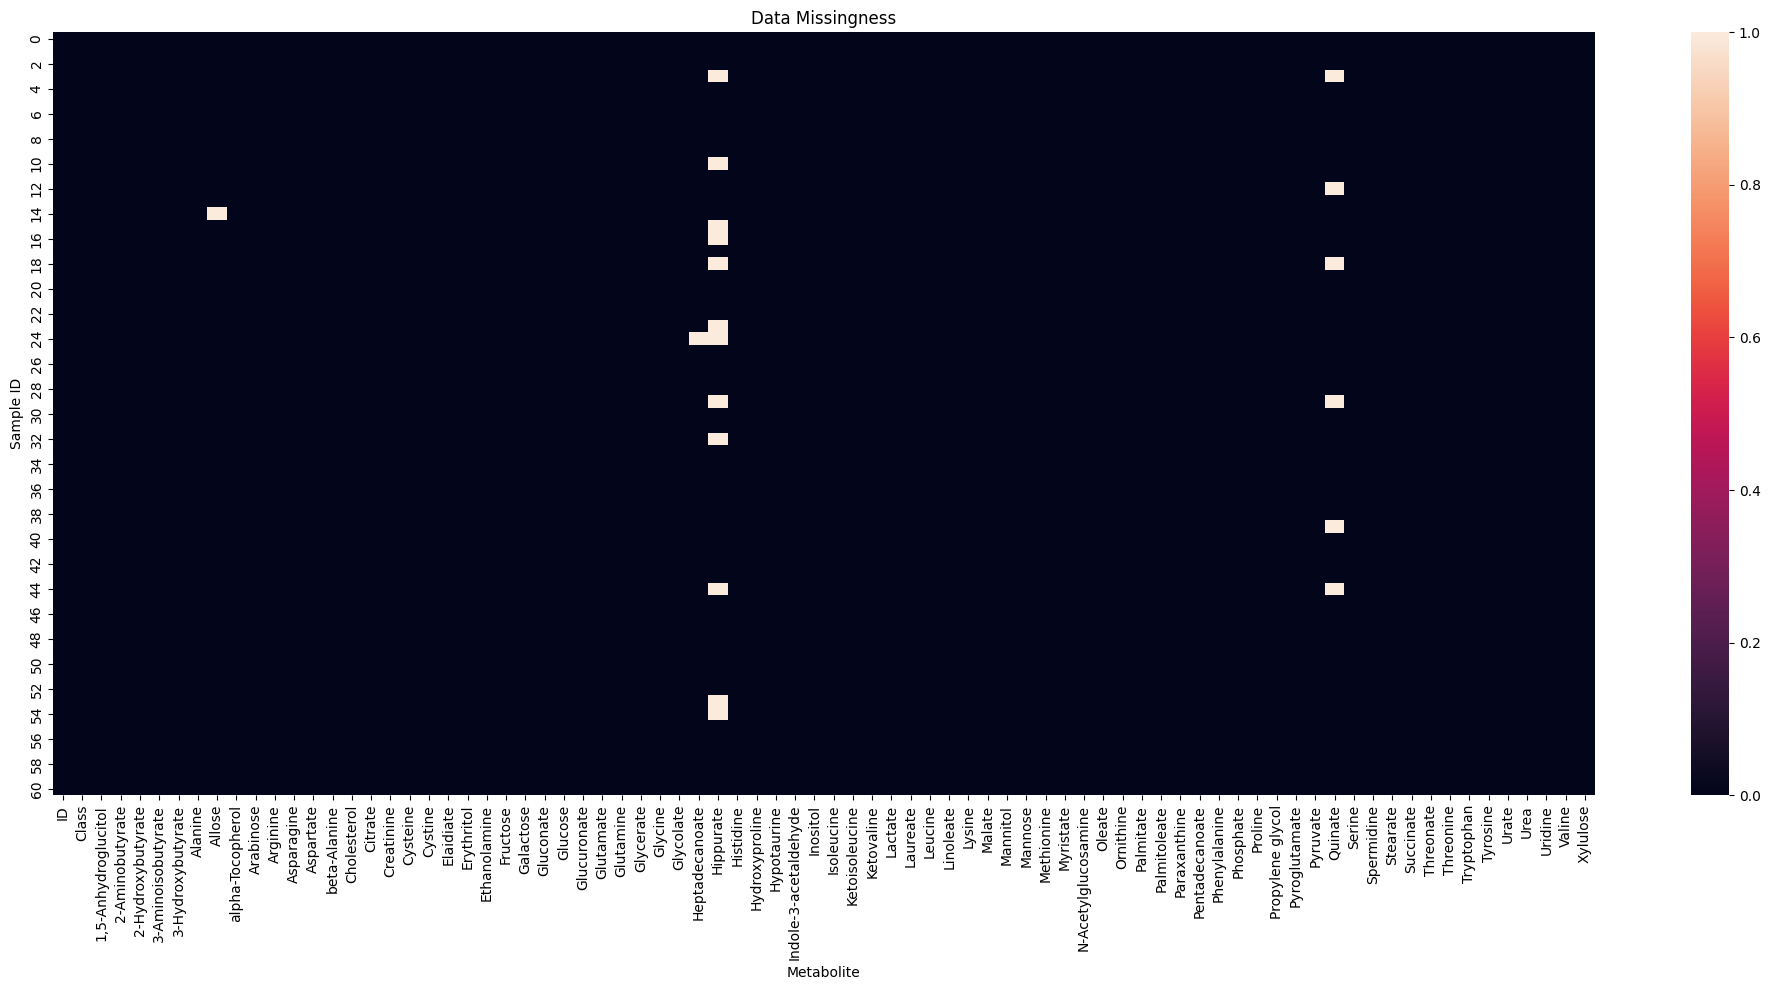

In [141]:
# Vizualise data missigness
plt.figure(figsize=(20, 10))
sns.heatmap(df.isnull())
plt.title("Data Missingness")
plt.ylabel("Sample ID")
plt.xlabel("Metabolite")
plt.tight_layout()

In [142]:
missing_values_summary(df)

🔍 Missing Values Summary:
+----------------+--------------------+-------------------+-------------------+-------------------+
|                |     Hippurate      |      Quinate      |  Heptadecanoate   |      Allose       |
+----------------+--------------------+-------------------+-------------------+-------------------+
| Missing Values |        12.0        |        6.0        |        1.0        |        1.0        |
|   Percentage   | 19.672131147540984 | 9.836065573770492 | 1.639344262295082 | 1.639344262295082 |
+----------------+--------------------+-------------------+-------------------+-------------------+


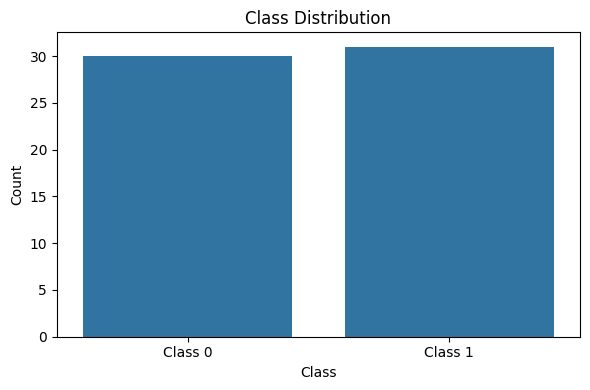

In [143]:
plt.figure(figsize=(6, 4))
sns.countplot(x="Class", data=df)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks([0, 1], labels=["Class 0", "Class 1"])
plt.tight_layout()
plt.show()

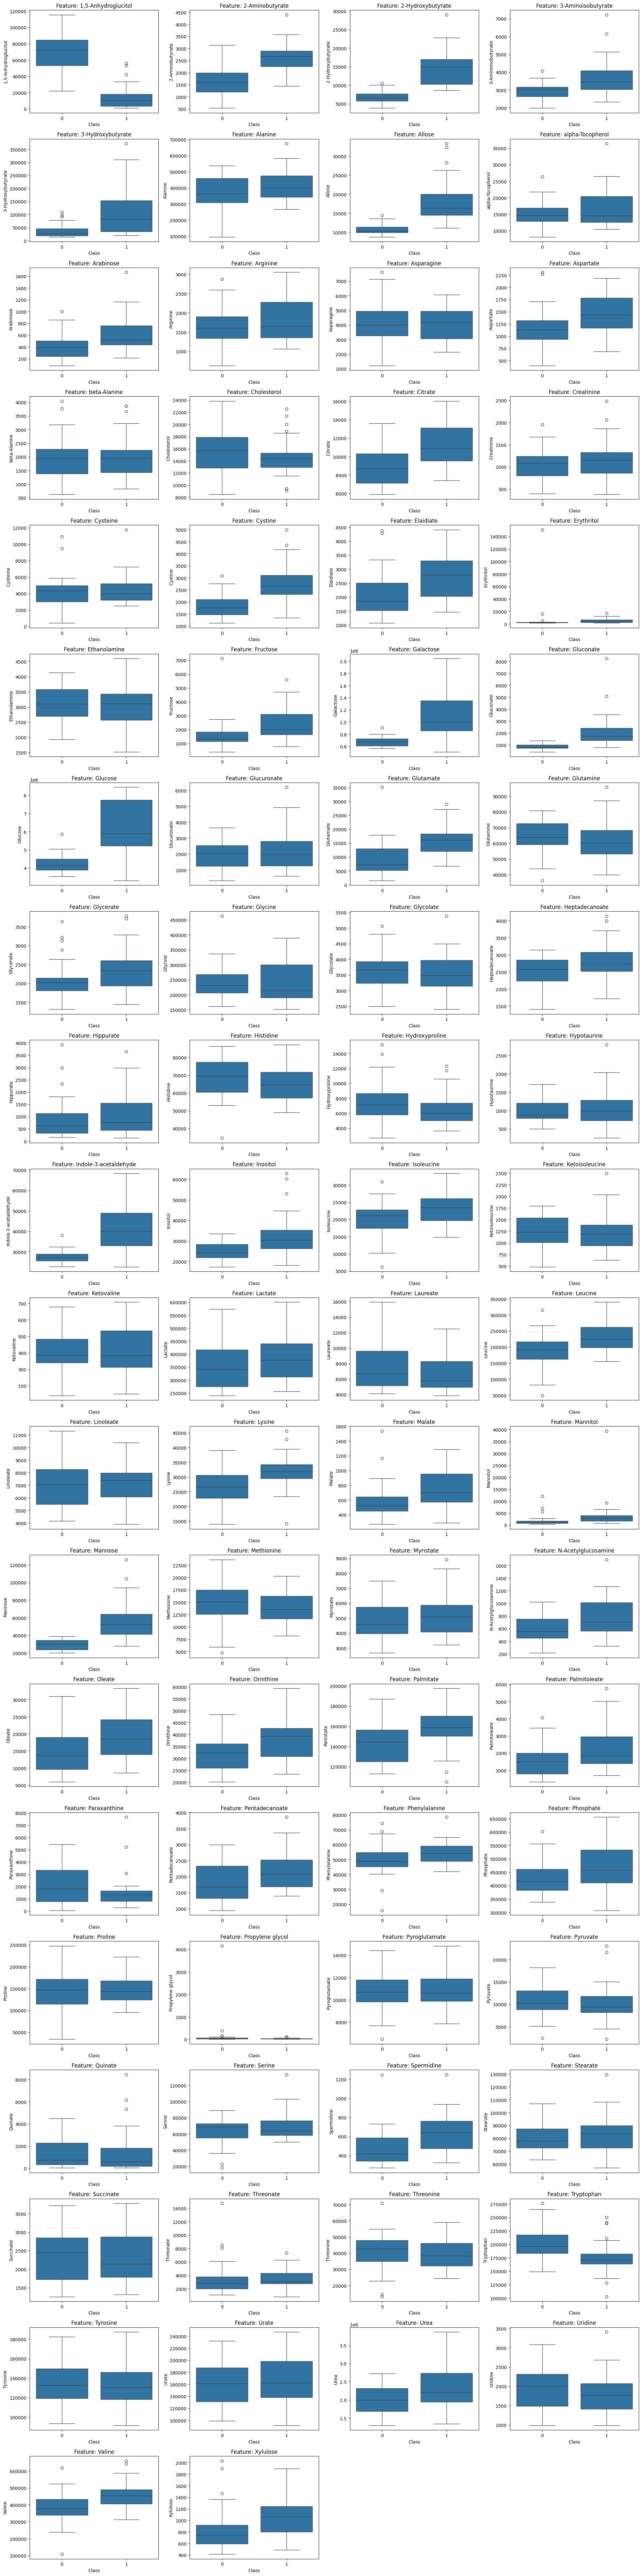

In [144]:
# plot box plots for each metabolite with the class labels
feature_cols = [col for col in df.columns if col != "ID" and col != "Class"]

# Grid set up
cols_per_row = 4
total_plots = len(feature_cols)
rows = math.ceil(total_plots / cols_per_row)

plt.figure(figsize=(cols_per_row * 5, rows * 4))

for i, col in enumerate(feature_cols):
    plt.subplot(rows, cols_per_row, i + 1)  # plt.subplots is 1-based not 0-based
    sns.boxplot(x="Class", y=col, data=df)
    plt.title(f"Feature: {col}")
    plt.tight_layout()

plt.show()

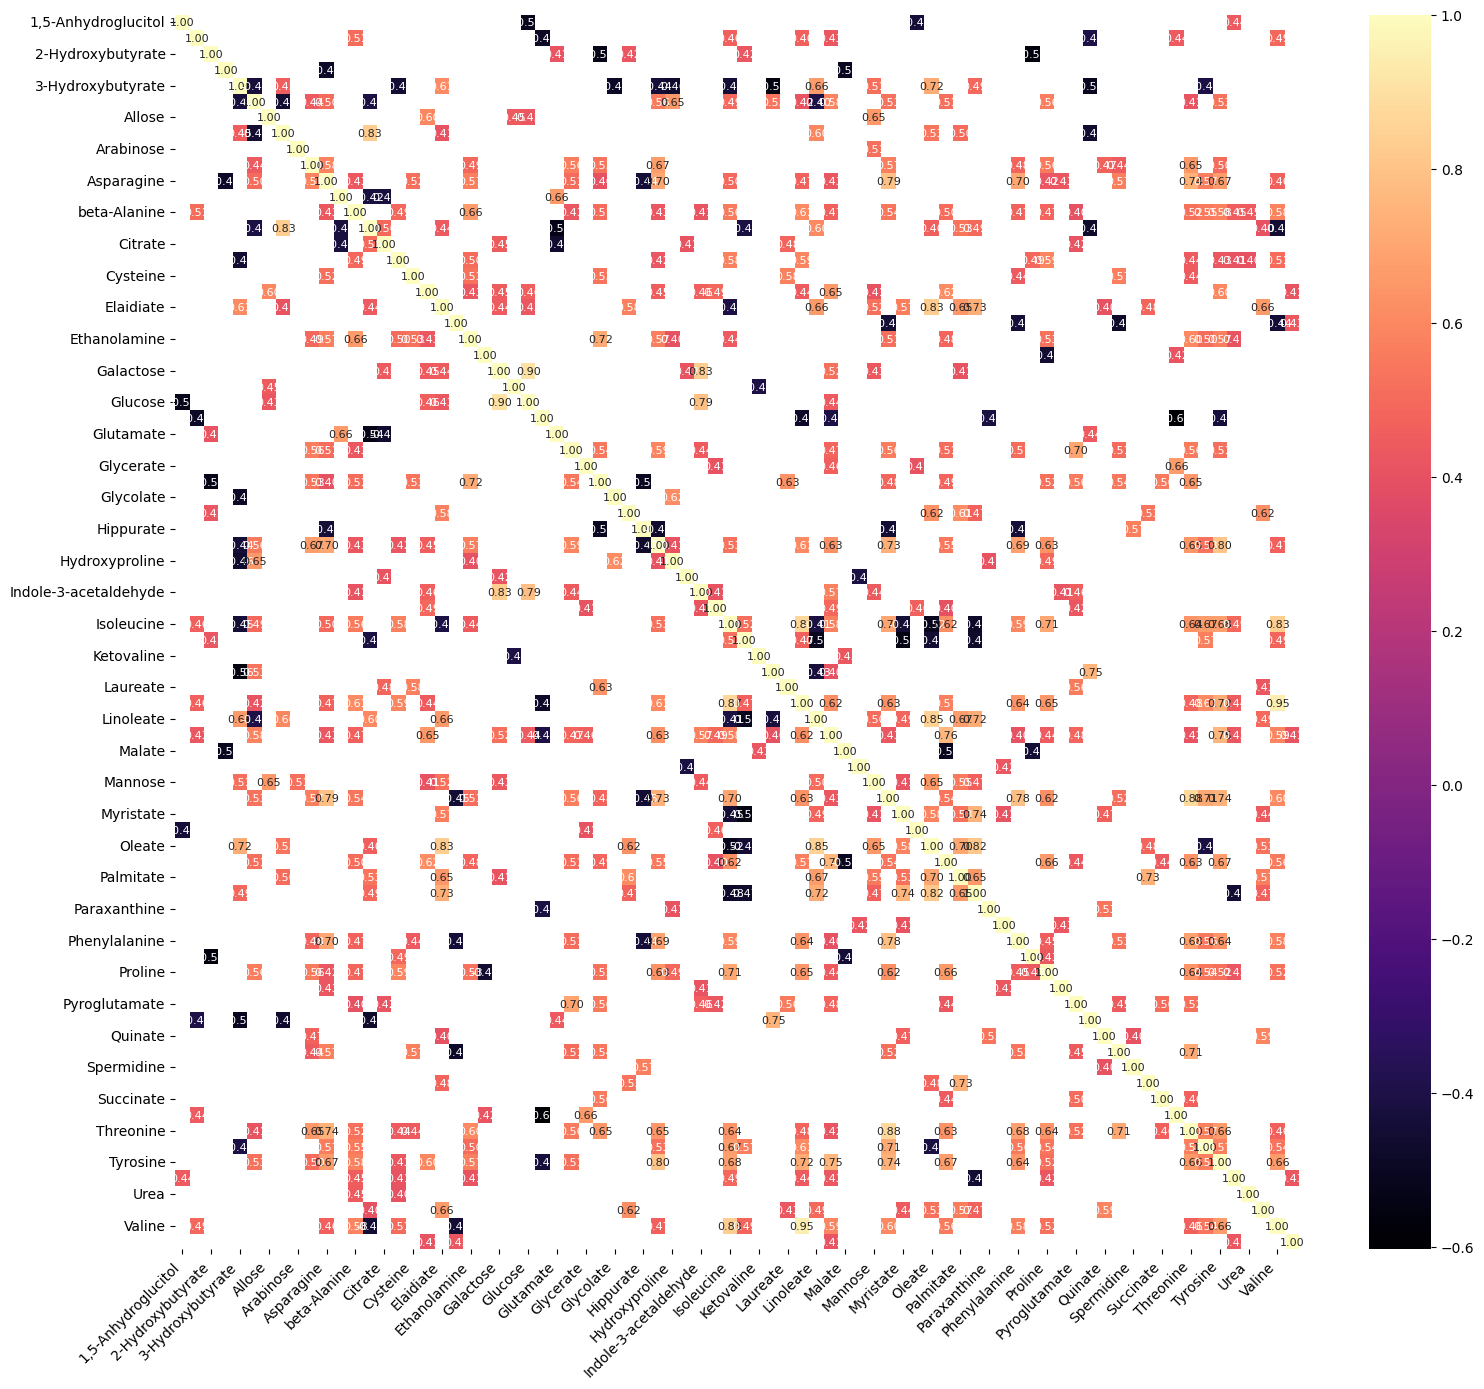

In [145]:
## Correlation Heatmap for Control group

# Compute correlation matrix and mask correlations with |r| < 0.4
corr_control = df[feature_cols][df["Class"] == 0].corr(method="spearman")
mask = np.abs(corr_control) < 0.4

# Generate the heatmap with correlation values
plt.figure(figsize=(16, 14))
sns.heatmap(
    corr_control,
    mask=mask,
    annot=True,
    fmt=".2f",  # Limit decimal places
    cmap="magma",  # Use a visually distinct color map
    annot_kws={"size": 8},
)  # Adjust annotation font size

# Improve tick label appearance
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

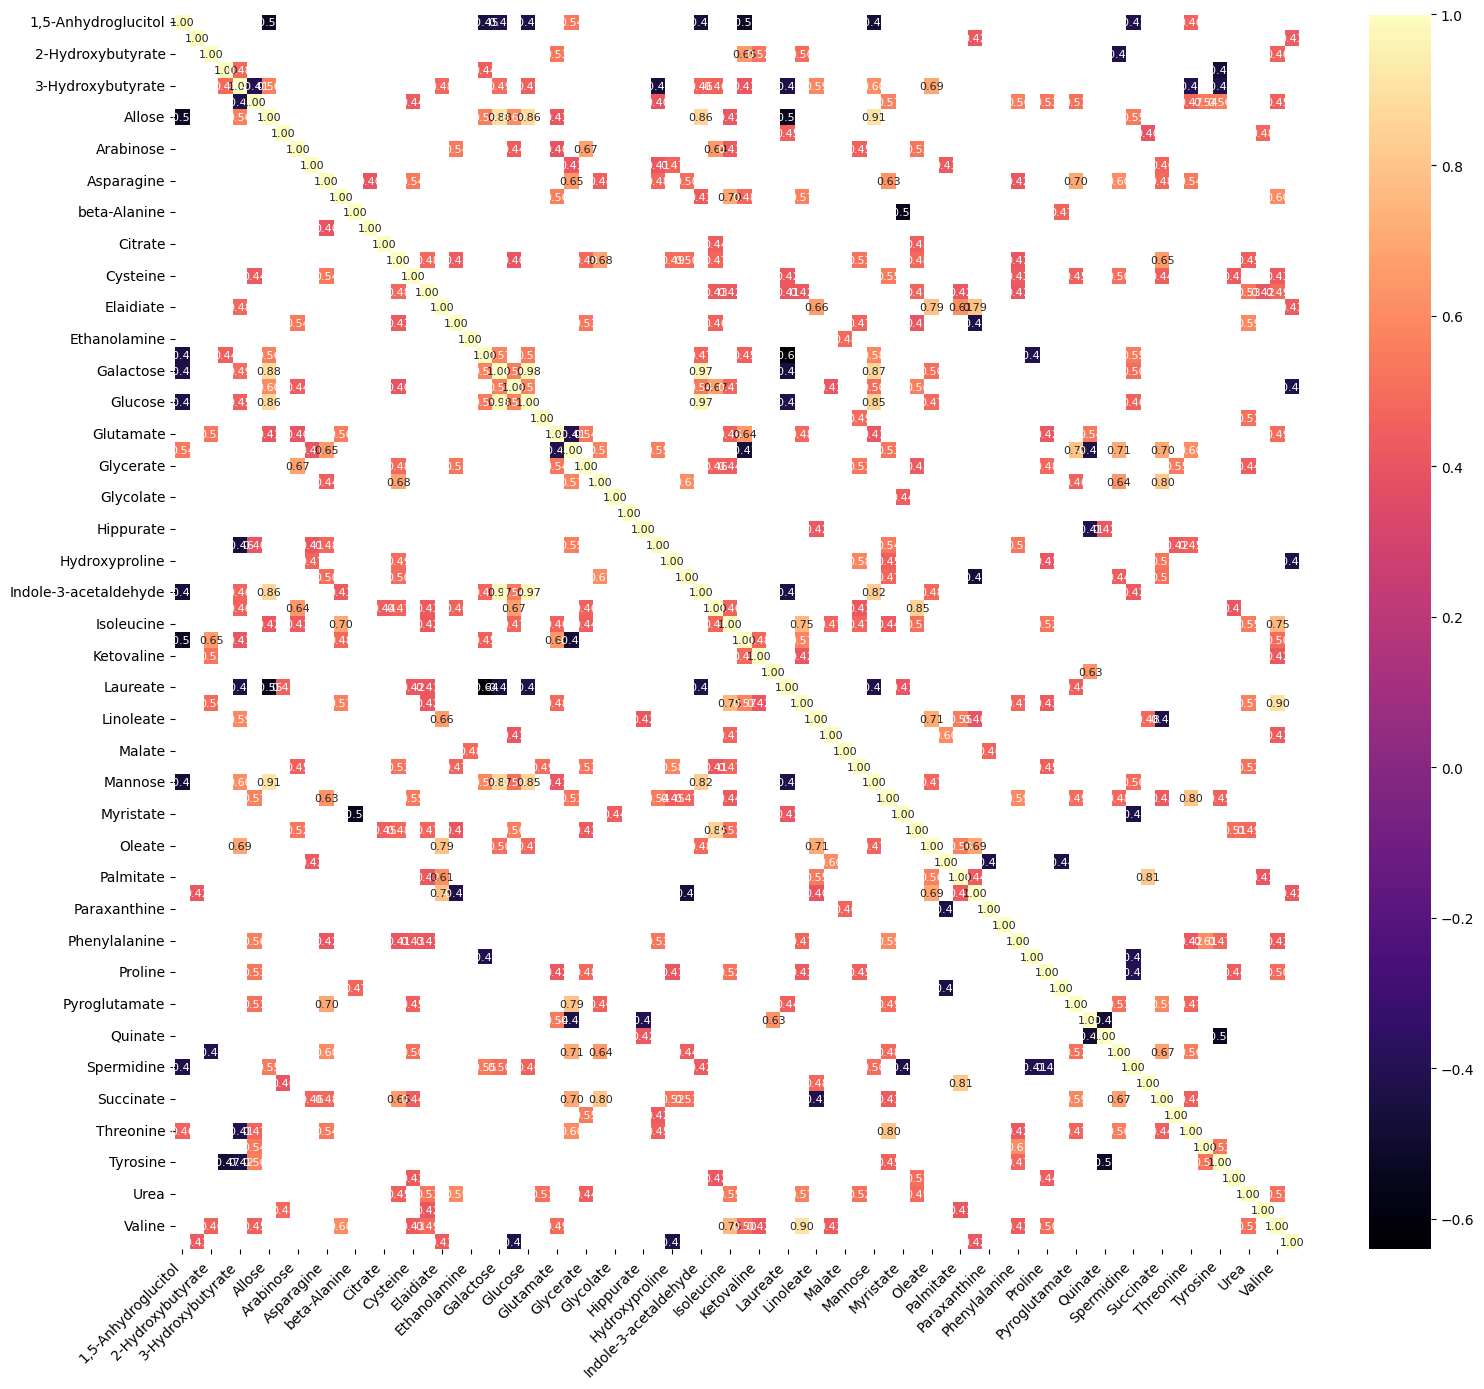

In [146]:
## Correlation Heatmap for T2D group

# Compute correlation matrix and mask correlations with |r| < 0.4
corr_t2d = df[feature_cols][df["Class"] == 1].corr(method="spearman")
mask = np.abs(corr_t2d) < 0.4

# Generate the heatmap with correlation values
plt.figure(figsize=(16, 14))
sns.heatmap(
    corr_t2d,
    mask=mask,
    annot=True,
    fmt=".2f",  # Limit decimal places
    cmap="magma",  # Use a visually distinct color map
    annot_kws={"size": 8},
)  # Adjust annotation font size

# Improve tick label appearance
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [147]:
def get_correlation_pairs(df: pd.DataFrame, threshold=0.4):

    # Compute the upper triangle of the correlation matrix (excluding diagonal)
    upper_triangle = df.where(np.triu(np.ones(df.shape), k=1).astype(bool))

    # Reshape into long format (feature pairs and correlation values)
    corr_pairs = upper_triangle.stack().reset_index()
    corr_pairs.columns = ["Feature_A", "Feature_B", "Spearman_r"]

    # Sort by correlation strength
    ## Get indecies of a sorted list of abs corr values and reindex the original df.
    corr_pairs = corr_pairs.reindex(
        corr_pairs["Spearman_r"].abs().sort_values(ascending=False).index
    )

    # Filter for strong correlations (e.g. r > 0.4)
    strong_corr = corr_pairs[
        (corr_pairs["Spearman_r"] > threshold) | (corr_pairs["Spearman_r"] < -threshold)
    ]
    strong_corr["Spearman_r"] = strong_corr["Spearman_r"].round(2)

    return strong_corr

In [148]:
## Create DataFrames with metabolite pairs and their respective Spearman correlations for Control group
corr_c = get_correlation_pairs(corr_control)

# # Save data into csv
# corr_c.to_csv("strong_corr_control.csv", index=False)

print(tabulate(corr_c.head(50), headers="keys", tablefmt="pretty"))

+------+-------------------+-----------------------+------------+
|      |     Feature_A     |       Feature_B       | Spearman_r |
+------+-------------------+-----------------------+------------+
| 2440 |      Leucine      |        Valine         |    0.95    |
| 1464 |     Galactose     |        Glucose        |    0.9     |
| 2617 |    Methionine     |       Threonine       |    0.88    |
| 2227 |    Isoleucine     |        Leucine        |    0.87    |
| 2449 |     Linoleate     |        Oleate         |    0.85    |
| 2260 |    Isoleucine     |        Valine         |    0.83    |
| 523  | alpha-Tocopherol  |      Cholesterol      |    0.83    |
| 1476 |     Galactose     | Indole-3-acetaldehyde |    0.83    |
| 1266 |     Elaidiate     |        Oleate         |    0.83    |
| 2680 |      Oleate       |     Palmitoleate      |    0.82    |
| 2051 |     Histidine     |       Tyrosine        |    0.8     |
| 763  |    Asparagine     |      Methionine       |    0.79    |
| 1583 |  

C:\Users\tomla\AppData\Local\Temp\ipykernel_37364\2944828167.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  strong_corr['Spearman_r'] = strong_corr['Spearman_r'].round(2)


In [149]:
## Create DataFrame with metabolite pairs and their respective Spearman correlations for T2D group
corr_t2d = get_correlation_pairs(corr_t2d)

# # Save data into csv
# corr_t2d.to_csv("strong_corr_t2d.csv", index=False)

print(tabulate(corr_t2d.head(50), headers="keys", tablefmt="pretty"))

+------+-----------------------+-----------------------+------------+
|      |       Feature_A       |       Feature_B       | Spearman_r |
+------+-----------------------+-----------------------+------------+
| 1464 |       Galactose       |        Glucose        |    0.98    |
| 1583 |        Glucose        | Indole-3-acetaldehyde |    0.97    |
| 1476 |       Galactose       | Indole-3-acetaldehyde |    0.97    |
| 488  |        Allose         |        Mannose        |    0.91    |
| 2440 |        Leucine        |        Valine         |    0.9     |
| 462  |        Allose         |       Galactose       |    0.88    |
| 1488 |       Galactose       |        Mannose        |    0.87    |
| 464  |        Allose         |        Glucose        |    0.86    |
| 476  |        Allose         | Indole-3-acetaldehyde |    0.86    |
| 1595 |        Glucose        |        Mannose        |    0.85    |
| 2196 |       Inositol        |  N-Acetylglucosamine  |    0.85    |
| 2153 | Indole-3-ac

C:\Users\tomla\AppData\Local\Temp\ipykernel_37364\2944828167.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  strong_corr['Spearman_r'] = strong_corr['Spearman_r'].round(2)


In [150]:
## Compute Fisher z-test for significance of correlation

# Rename columns to distinguish
control_corr_df = corr_c.rename(columns={"Spearman_r": "r_control"})
t2d_corr_df = corr_t2d.rename(columns={"Spearman_r": "r_T2D"})

# Merge on Feature_A and Feature_B
merged = pd.merge(
    control_corr_df, t2d_corr_df, on=["Feature_A", "Feature_B"], how="inner"
)

# Compute absolute difference
merged["abs_delta_r"] = (merged["r_control"] - merged["r_T2D"]).abs()

# Sort by largest difference
merged = merged.sort_values(by="abs_delta_r", ascending=False)

n_control = len(df[df["Class"] == 0])  # e.g., 30
n_t2d = len(df[df["Class"] == 1])  # e.g., 31

# Avoid ±1 correlations which break z-transform
merged["r_control"] = merged["r_control"].clip(-0.9999, 0.9999)
merged["r_T2D"] = merged["r_T2D"].clip(-0.9999, 0.9999)

# Apply Fisher z-transform
merged["z_control"] = 0.5 * np.log(
    (1 + merged["r_control"]) / (1 - merged["r_control"])
)
merged["z_T2D"] = 0.5 * np.log((1 + merged["r_T2D"]) / (1 - merged["r_T2D"]))

# Compute z-diff and p-value
merged["z_score"] = (merged["z_control"] - merged["z_T2D"]) / np.sqrt(
    1 / (n_control - 3) + 1 / (n_t2d - 3)
)
merged["p_value"] = 2 * (1 - norm.cdf(np.abs(merged["z_score"])))

# Save to csv
merged.to_csv("corr_diff.csv", index=False)

In [165]:
merged_significant = merged[merged["p_value"] < 0.05].copy().round(2)
merged_significant["p_value"] = merged_significant["p_value"].apply(
    lambda x: "< 1e-16" if x == 0 else f"{x:.2e}"
)
print(tabulate(merged_significant.head(50), headers="keys", tablefmt="pretty"))

+----+-----------------------+-----------------------+-----------+-------+-------------+-----------+-------+---------+----------+
|    |       Feature_A       |       Feature_B       | r_control | r_T2D | abs_delta_r | z_control | z_T2D | z_score | p_value  |
+----+-----------------------+-----------------------+-----------+-------+-------------+-----------+-------+---------+----------+
| 88 |       Galactose       |        Mannose        |   0.43    | 0.87  |    0.44     |   0.46    | 1.33  |  -3.24  | < 1e-16  |
| 89 |        Allose         |        Glucose        |   0.43    | 0.86  |    0.43     |   0.46    | 1.29  |  -3.09  | < 1e-16  |
| 80 |       Inositol        |  N-Acetylglucosamine  |   0.46    | 0.85  |    0.39     |    0.5    | 1.26  |  -2.81  | < 1e-16  |
| 84 | Indole-3-acetaldehyde |        Mannose        |   0.44    | 0.82  |    0.38     |   0.47    | 1.16  |  -2.54  | 1.00e-02 |
| 37 |        Allose         |        Mannose        |   0.65    | 0.91  |    0.26     |  

# Spearman Correlation Analysis of Metabolites — Focus on Type 2 Diabetes
Several metabolite pairs demonstrated substantial and statistically significant shifts in their interrelationships. For example, the correlation between galactose and mannose increased markedly from ρ = 0.43 in controls to ρ = 0.87 in T2D (p = 0.0012), suggesting a disease-related strengthening of co-regulation among hexose sugars. This may reflect altered hepatic processing or intestinal absorption of these monosaccharides under insulin-resistant conditions.

Similarly, the relationship between allose and glucose intensified significantly in T2D (ρ = 0.86) compared to controls (ρ = 0.43, p = 0.002), reinforcing the notion of impaired or compensatory sugar handling pathways. Notably, indole-3-acetaldehyde and mannose also showed an increased coupling in T2D (ρ = 0.82 vs. 0.44, p = 0.011), supporting a potential link between microbial metabolism and host glycemic control in diabetes.

Other shifts were observed in lipid metabolism. For instance, the association between linoleate and palmitoleate decreased from a strong positive correlation in controls (ρ = 0.72) to a weaker association in T2D (ρ = 0.40, p = 0.073), hinting at disrupted coordination in unsaturated fatty acid regulation—possibly due to altered lipogenesis or oxidative stress responses in diabetic states.

Additionally, inositol and N-acetylglucosamine, both involved in signaling and glycosylation, exhibited enhanced correlation in T2D (ρ = 0.85 vs. 0.46, p = 0.0049), suggesting broader perturbations in carbohydrate modification pathways.

Overall, this analysis reveals that T2D not only alters metabolite levels but also reshapes the underlying correlation architecture of the metabolome. Such rewiring of metabolic networks could reflect compensatory mechanisms, pathway bottlenecks, or shared upstream regulatory dysfunctions characteristic of T2D pathophysiology.




C:\Users\tomla\AppData\Local\Temp\ipykernel_37364\3945858742.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered["sorted_pair"] = filtered.apply(lambda row: tuple(sorted([row["Feature A"], row["Feature B"]])), axis=1)


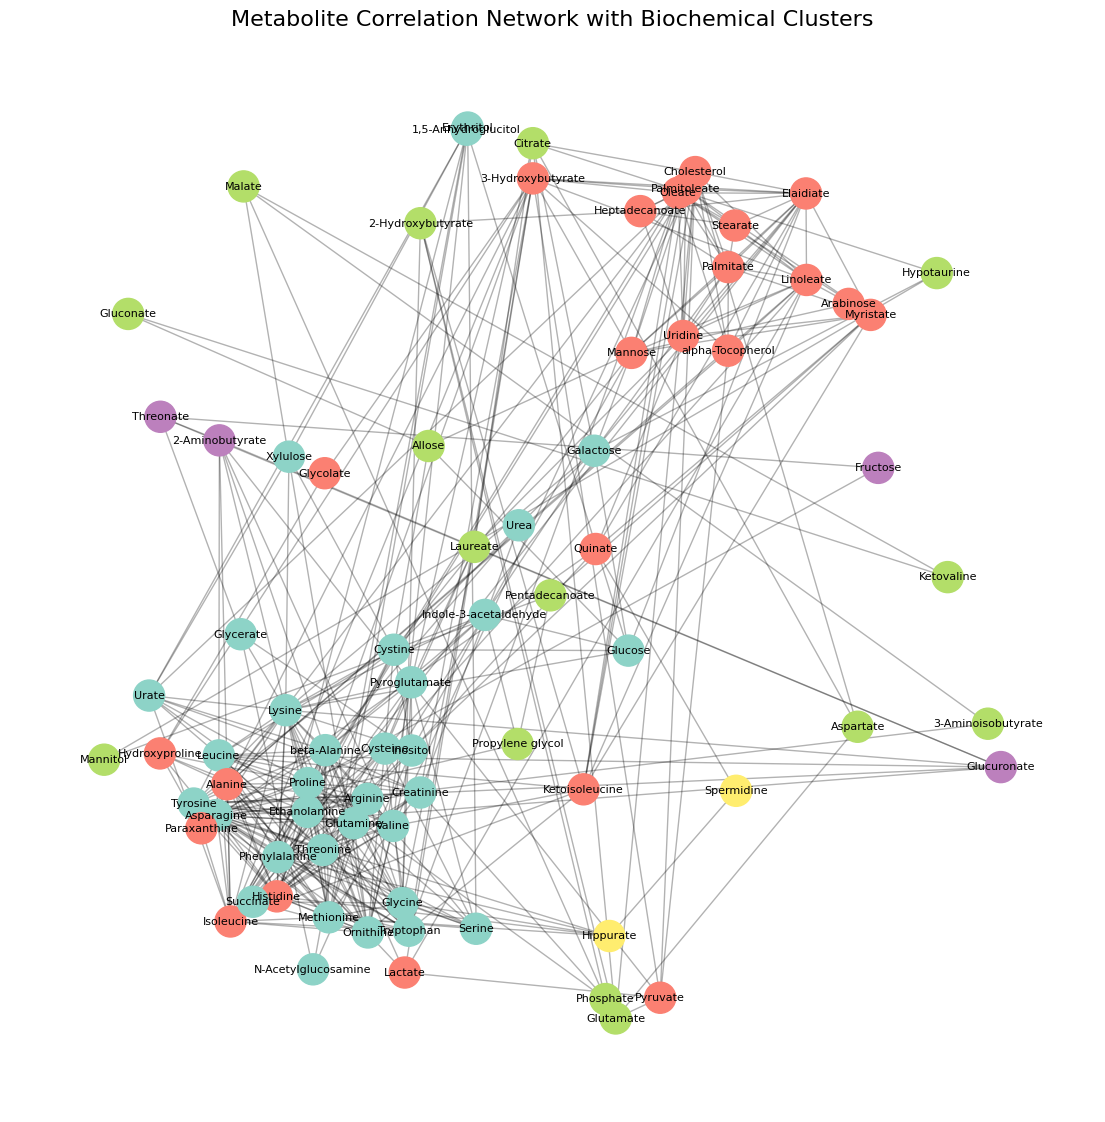

In [167]:
# Create Network Graph
corr_pairs = corr_control.stack().reset_index()
corr_pairs.columns = ["Feature A", "Feature B", "Correlation"]

# Filter: exclude self-correlations and weak ones
filtered = corr_pairs[
    (corr_pairs["Feature A"] != corr_pairs["Feature B"])
    & (corr_pairs["Correlation"].abs() >= 0.4)
]

# Remove duplicate edges (A–B and B–A)
filtered["sorted_pair"] = filtered.apply(
    lambda row: tuple(sorted([row["Feature A"], row["Feature B"]])), axis=1
)
filtered = filtered.drop_duplicates(subset="sorted_pair").drop(columns="sorted_pair")

G = nx.Graph()
# Add edges with correlation as weight
for _, row in filtered.iterrows():
    G.add_edge(row["Feature A"], row["Feature B"], weight=row["Correlation"])

communities = list(greedy_modularity_communities(G))

# Map nodes to community index
community_map = {}
for i, cluster in enumerate(communities):
    for node in cluster:
        community_map[node] = i

# Assign community ID to node attributes
nx.set_node_attributes(G, community_map, "module")

plt.figure(figsize=(14, 14))
pos = nx.spring_layout(G, seed=42, k=0.4)

# Node color by community
node_colors = [community_map[node] for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap=plt.cm.Set3, node_size=500)
nx.draw_networkx_edges(G, pos, alpha=0.3)
nx.draw_networkx_labels(G, pos, font_size=8)

plt.title("Metabolite Correlation Network with Biochemical Clusters", fontsize=16)
plt.axis("off")
plt.show()

## 3. Basic Statistics

In [155]:
# test for normal distribution
results = []

for col in feature_cols:
    for cls in df["Class"].unique():
        data = df[df["Class"] == cls][col]
        stat, p = shapiro(data)
        results.append(
            {
                "feature": col,
                "class": cls,
                "W-statistics": stat,
                "p-value": p,
                "Normal?": "Yes" if p > 0.05 else "No",
            }
        )

normality_df = pd.DataFrame(results)
normality_df

,feature,class,W-statistics,p-value,Normal?
0,"1,5-Anhydroglucitol",0,0.98,0.93,Yes
1,"1,5-Anhydroglucitol",1,0.80,0.00,No
2,2-Aminobutyrate,0,0.98,0.84,Yes
3,2-Aminobutyrate,1,0.96,0.39,Yes
4,2-Hydroxybutyrate,0,0.97,0.45,Yes
...,...,...,...,...,...
151,Uridine,1,0.94,0.07,Yes
152,Valine,0,0.95,0.15,Yes
153,Valine,1,0.96,0.32,Yes
154,Xylulose,0,0.84,0.00,No


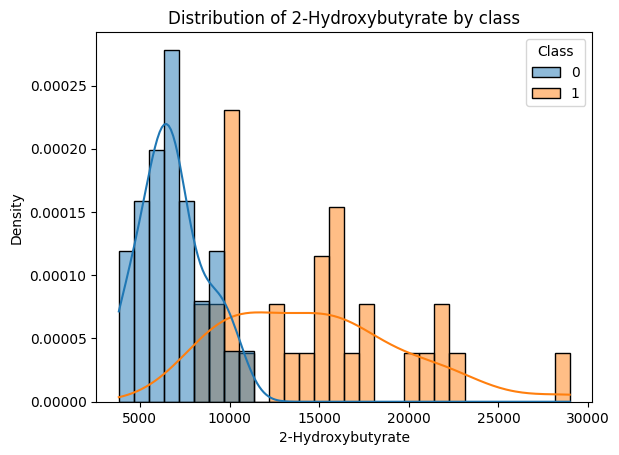

In [156]:
sns.histplot(
    data=df,
    x="2-Hydroxybutyrate",
    hue="Class",
    bins=30,
    kde=True,
    stat="density",
    common_norm=False,
)
plt.title("Distribution of 2-Hydroxybutyrate by class")
plt.show()

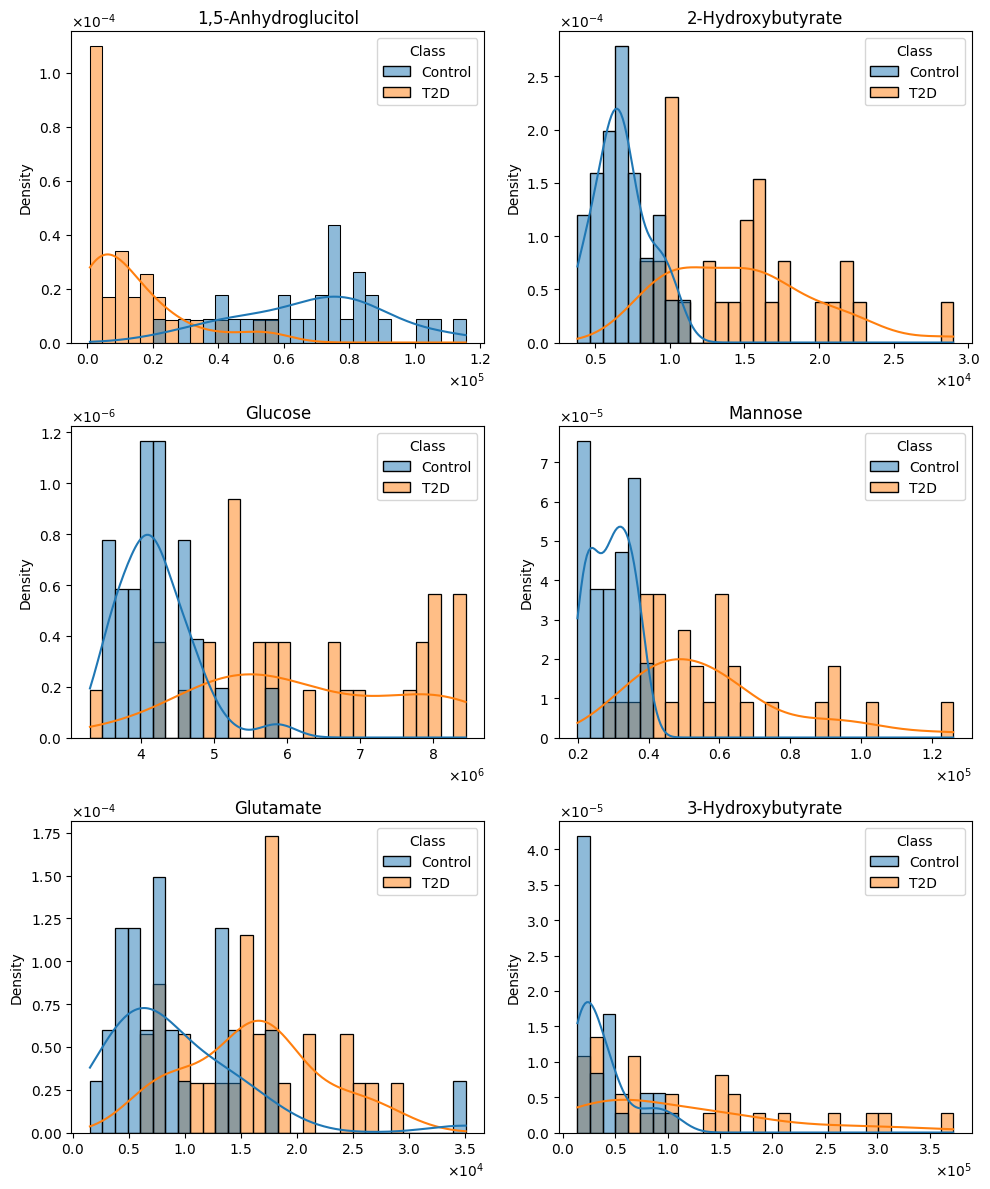

In [157]:
features_dist = [
    "1,5-Anhydroglucitol",
    "2-Hydroxybutyrate",
    "Glucose",
    "Mannose",
    "Glutamate",
    "3-Hydroxybutyrate",
]

cols_per_row = 2
total_plots = len(features_dist)
rows = math.ceil(total_plots / cols_per_row)

plt.figure(figsize=(cols_per_row * 5, rows * 4))

df_plot = df.copy()
df_plot["Class"] = df_plot["Class"].map({0: "Control", 1: "T2D"})

for i, col in enumerate(features_dist):
    plt.subplot(rows, cols_per_row, i + 1)  # plt.subplots is 1-based not 0-based
    sns.histplot(
        data=df_plot,
        x=col,
        hue="Class",
        bins=30,
        kde=True,
        stat="density",
        common_norm=False,
    )
    plt.title(col)
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-2, 2))  # Triggers sci notation only when needed
    formatter.set_scientific(True)
    formatter.set_useOffset(False)
    formatter_x = ScalarFormatter(useMathText=True)
    formatter_x.set_powerlimits((-2, 2))  # Triggers sci notation only when needed
    formatter_x.set_scientific(True)
    formatter_x.set_useOffset(False)
    plt.gca().yaxis.set_major_formatter(formatter)
    plt.gca().xaxis.set_major_formatter(formatter_x)
    plt.xlabel("")
    plt.tight_layout()

plt.show()

C:\Users\tomla\AppData\Local\Temp\ipykernel_37364\3539357636.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  heatmap_numeric = heatmap_data.replace({"Yes": 1, "No": 0, "Too few samples": None})


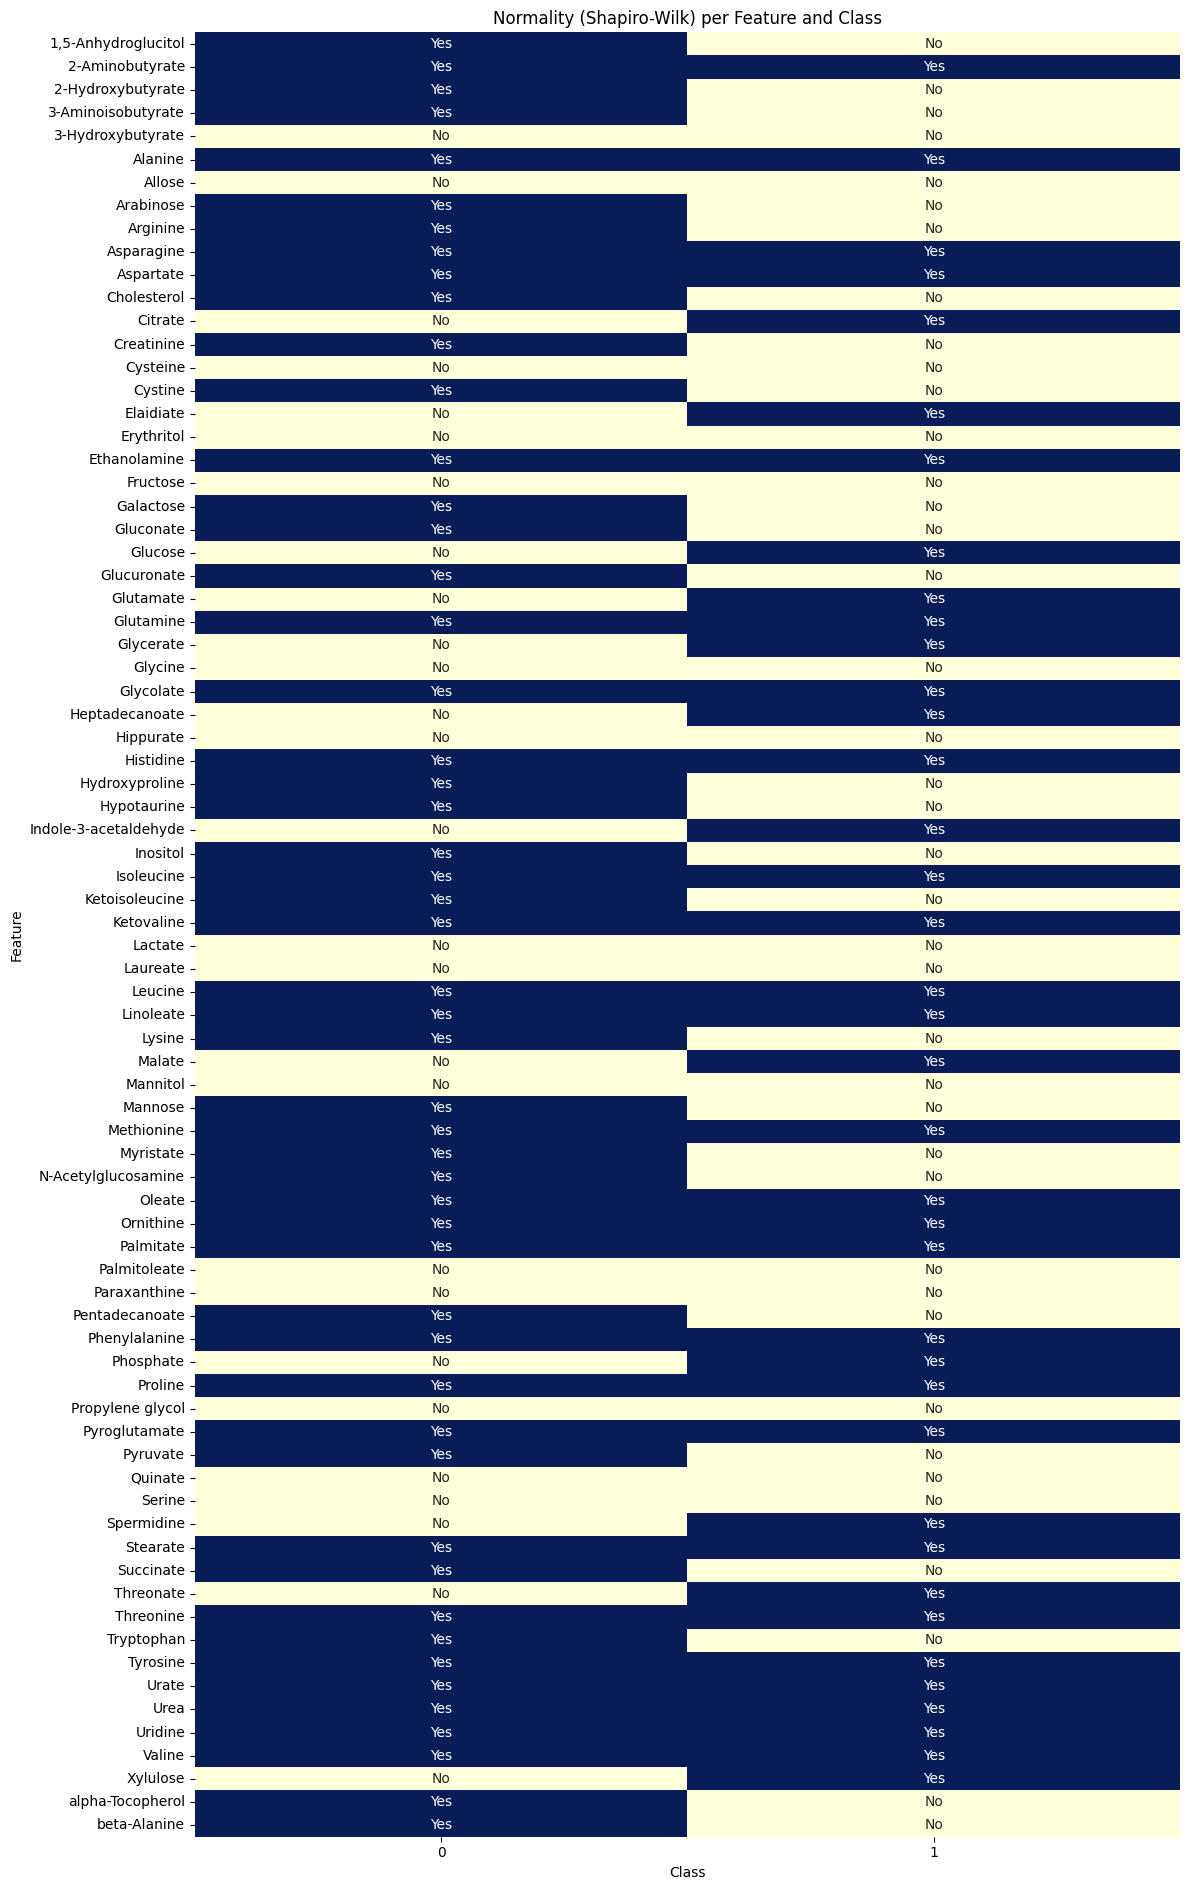

In [158]:
# Vizualise the results as heatmap for all features
heatmap_data = normality_df.pivot(index="feature", columns="class", values="Normal?")
heatmap_numeric = heatmap_data.replace({"Yes": 1, "No": 0, "Too few samples": None})
plt.figure(figsize=(12, len(feature_cols) // 4))
sns.heatmap(heatmap_numeric, annot=heatmap_data, fmt="", cmap="YlGnBu", cbar=False)
plt.title("Normality (Shapiro-Wilk) per Feature and Class")
plt.xlabel("Class")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

## 4. Univariate analysis

Since the data is not normally distributed, we will use the Mann–Whitney U test to compare the means between the two classes for each feature. This will become a starting point for future feature selection

In [159]:
### 1. Mann–Whitney U test

results = []

# Run Mann–Whitney U test for each feature
for feature in feature_cols:
    group_0 = df[df["Class"] == 0][feature]
    group_1 = df[df["Class"] == 1][feature]

    # impute missing values using median to prevent NaN p-values
    group_0 = (
        SimpleImputer(strategy="median")
        .fit_transform(group_0.values.reshape(-1, 1))
        .flatten()
    )
    group_1 = (
        SimpleImputer(strategy="median")
        .fit_transform(group_1.values.reshape(-1, 1))
        .flatten()
    )

    stat, p = mannwhitneyu(group_0, group_1, alternative="two-sided")

    results.append(
        {
            "Feature": feature,
            "U-statistic": stat,
            "p-value": p,
            "Significant?": "Yes" if p < 0.05 else "No",
        }
    )

# Convert to DataFrame
mw_df = pd.DataFrame(results)

# Apply Benjamini–Hochberg correction (FDR-False Discovery Rate) (to reduce Type I error (false positive))
_, pvals_corrected, _, _ = multipletests(mw_df["p-value"], method="fdr_bh")
mw_df["Corrected p-value"] = pvals_corrected
mw_df["Significant (FDR < 0.05)"] = pvals_corrected < 0.05

# Sort by p-value
mw_df = mw_df.sort_values(by="Corrected p-value")

# Show or export results
mw_df.tail()

,Feature,U-statistic,p-value,Significant?,Corrected p-value,Significant (FDR < 0.05)
10,Asparagine,473.00,0.91,No,0.95,False
40,Ketovaline,456.00,0.90,No,0.95,False
25,Glucuronate,464.00,0.99,No,1.00,False
12,beta-Alanine,465.00,1.00,No,1.00,False
72,Tyrosine,467.00,0.98,No,1.00,False


In [160]:
# Check for NaN p-values
mw_df.info()

nan_pvals = mw_df[mw_df["p-value"].isna()]
nan_pvals

<class 'pandas.core.frame.DataFrame'>
Index: 78 entries, 0 to 72
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Feature                   78 non-null     object 
 1   U-statistic               78 non-null     float64
 2   p-value                   78 non-null     float64
 3   Significant?              78 non-null     object 
 4   Corrected p-value         78 non-null     float64
 5   Significant (FDR < 0.05)  78 non-null     bool   
dtypes: bool(1), float64(3), object(2)
memory usage: 3.7+ KB


,Feature,U-statistic,p-value,Significant?,Corrected p-value,Significant (FDR < 0.05)


In [161]:
# Show features with significant p-values between classes
signinificant_features = mw_df[mw_df["Significant (FDR < 0.05)"] == True]

print(f"There are {len(signinificant_features)} significant features.")
signinificant_features

There are 34 significant features.


,Feature,U-statistic,p-value,Significant?,Corrected p-value,Significant (FDR < 0.05)
0,"1,5-Anhydroglucitol",904.00,0.00,Yes,0.00,True
2,2-Hydroxybutyrate,24.00,0.00,Yes,0.00,True
6,Allose,28.00,0.00,Yes,0.00,True
23,Gluconate,27.00,0.00,Yes,0.00,True
48,Mannose,32.00,0.00,Yes,0.00,True
22,Galactose,62.00,0.00,Yes,0.00,True
24,Glucose,67.00,0.00,Yes,0.00,True
36,Indole-3-acetaldehyde,77.00,0.00,Yes,0.00,True
17,Cystine,124.00,0.00,Yes,0.00,True
1,2-Aminobutyrate,141.00,0.00,Yes,0.00,True


In [162]:
def cliffs_delta(x, y):
    """
    Computes Cliff's delta effect size between two samples.
    Returns the delta value and its qualitative interpretation.
    """
    n_x = len(x)
    n_y = len(y)
    total_pairs = n_x * n_y

    greater = sum(1 for xi, yi in product(x, y) if xi > yi)
    less = sum(1 for xi, yi in product(x, y) if xi < yi)

    delta = (greater - less) / total_pairs

    abs_delta = abs(delta)
    if abs_delta < 0.147:
        magnitude = "negligible"
    elif abs_delta < 0.33:
        magnitude = "small"
    elif abs_delta < 0.474:
        magnitude = "medium"
    else:
        magnitude = "large"

    return delta, magnitude

In [ ]:
### 2. Biological inference

significant_metabolites = signinificant_features["Feature"].values
control = df[df["Class"] == 0].drop(columns=["ID"])
cases = df[df["Class"] == 1].drop(columns=["ID"])

group_control = (
    SimpleImputer(strategy="median")
    .fit_transform(control.values.reshape(-1, 1))
    .flatten()
)
group_cases = (
    SimpleImputer(strategy="median")
    .fit_transform(cases.values.reshape(-1, 1))
    .flatten()
)

results = []

for metabolite in significant_metabolites:
    control_median = control[metabolite].median()
    control_values = control[metabolite]
    cases_values = cases[metabolite]

    n_higher = (cases_values > control_median).sum()
    n_lower = (cases_values < control_median).sum()
    total = len(cases_values)

    delta, magnitude = cliffs_delta(cases_values, control_values)

    results.append(
        {
            "Metabolite": metabolite,
            "Control Median": control_median,
            "N T2D Higher": n_higher,
            "N T2D Lower": n_lower,
            "Total T2D": total,
            "Proportion Higher": n_higher / total,
            "Proportion Lower": n_lower / total,
            "Cliffs Delta": delta,
            "Effect Size": magnitude,
        }
    )

biological_df = pd.DataFrame(results)
biological_df

,Metabolite,Control Median,N T2D Higher,N T2D Lower,Total T2D,Proportion Higher,Proportion Lower,Cliffs Delta,Effect Size
0,"1,5-Anhydroglucitol",72441.11,0,31,31,0.00,1.00,-0.94,large
1,2-Hydroxybutyrate,6667.66,31,0,31,1.00,0.00,0.95,large
2,Allose,10301.21,31,0,31,1.00,0.00,0.91,large
3,Gluconate,828.79,30,1,31,0.97,0.03,0.94,large
4,Mannose,29906.15,30,1,31,0.97,0.03,0.93,large
5,Galactose,672210.16,30,1,31,0.97,0.03,0.87,large
6,Glucose,4143208.24,30,1,31,0.97,0.03,0.86,large
7,Indole-3-acetaldehyde,27286.89,29,2,31,0.94,0.06,0.83,large
8,Cystine,1751.66,29,2,31,0.94,0.06,0.73,large
9,2-Aminobutyrate,1608.16,28,3,31,0.90,0.10,0.70,large


In [171]:
bio_large = biological_df[biological_df["Effect Size"] == "large"]
print(tabulate(bio_large.round(2), headers="keys", tablefmt="pretty"))

+----+-----------------------+----------------+--------------+-------------+-----------+-------------------+------------------+--------------+-------------+
|    |      Metabolite       | Control Median | N T2D Higher | N T2D Lower | Total T2D | Proportion Higher | Proportion Lower | Cliffs Delta | Effect Size |
+----+-----------------------+----------------+--------------+-------------+-----------+-------------------+------------------+--------------+-------------+
| 0  |  1,5-Anhydroglucitol  |    72441.11    |      0       |     31      |    31     |        0.0        |       1.0        |    -0.94     |    large    |
| 1  |   2-Hydroxybutyrate   |    6667.66     |      31      |      0      |    31     |        1.0        |       0.0        |     0.95     |    large    |
| 2  |        Allose         |    10301.21    |      31      |      0      |    31     |        1.0        |       0.0        |     0.91     |    large    |
| 3  |       Gluconate       |     828.79     |      30   

In [169]:
# df.to_csv("ST001906_1.csv", index=False)
# Save data into csv
biological_df.to_csv("biological_inference.csv", index=False)
signinificant_features.to_csv("significant_features.csv", index=False)

In [ ]:
metabolites = signinificant_features["Feature"].values
significance = signinificant_features["Corrected p-value"].values

pvals = dict(zip(metabolites, significance))

C:\Users\tomla\AppData\Local\Temp\ipykernel_37364\3580571566.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\tomla\AppData\Local\Temp\ipykernel_37364\3580571566.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Control vs. T2D: Custom statistical test, P_val:5.912e-09
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Control vs. T2D: Custom statistical test, P_val:5.912e-09


C:\Users\tomla\AppData\Local\Temp\ipykernel_37364\3580571566.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\tomla\AppData\Local\Temp\ipykernel_37364\3580571566.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\tomla\AppData\Local\Temp\ipykernel_37364\3580571566.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Control vs. T2D: Custom statistical test, P_val:6.854e-09
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Control vs. T2D: Custom statistical test, P_val:5.912e-09
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Control vs. T2D: Custom statistical test, P_val:5.912e-09


C:\Users\tomla\AppData\Local\Temp\ipykernel_37364\3580571566.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\tomla\AppData\Local\Temp\ipykernel_37364\3580571566.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\tomla\AppData\Local\Temp\ipykernel_37364\3580571566.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Control vs. T2D: Custom statistical test, P_val:8.290e-08
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Control vs. T2D: Custom statistical test, P_val:2.212e-07
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Control vs. T2D: Custom statistical test, P_val:1.090e-07
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Control vs. T2D: Custom statistical test, P_val:7.808e-06


C:\Users\tomla\AppData\Local\Temp\ipykernel_37364\3580571566.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


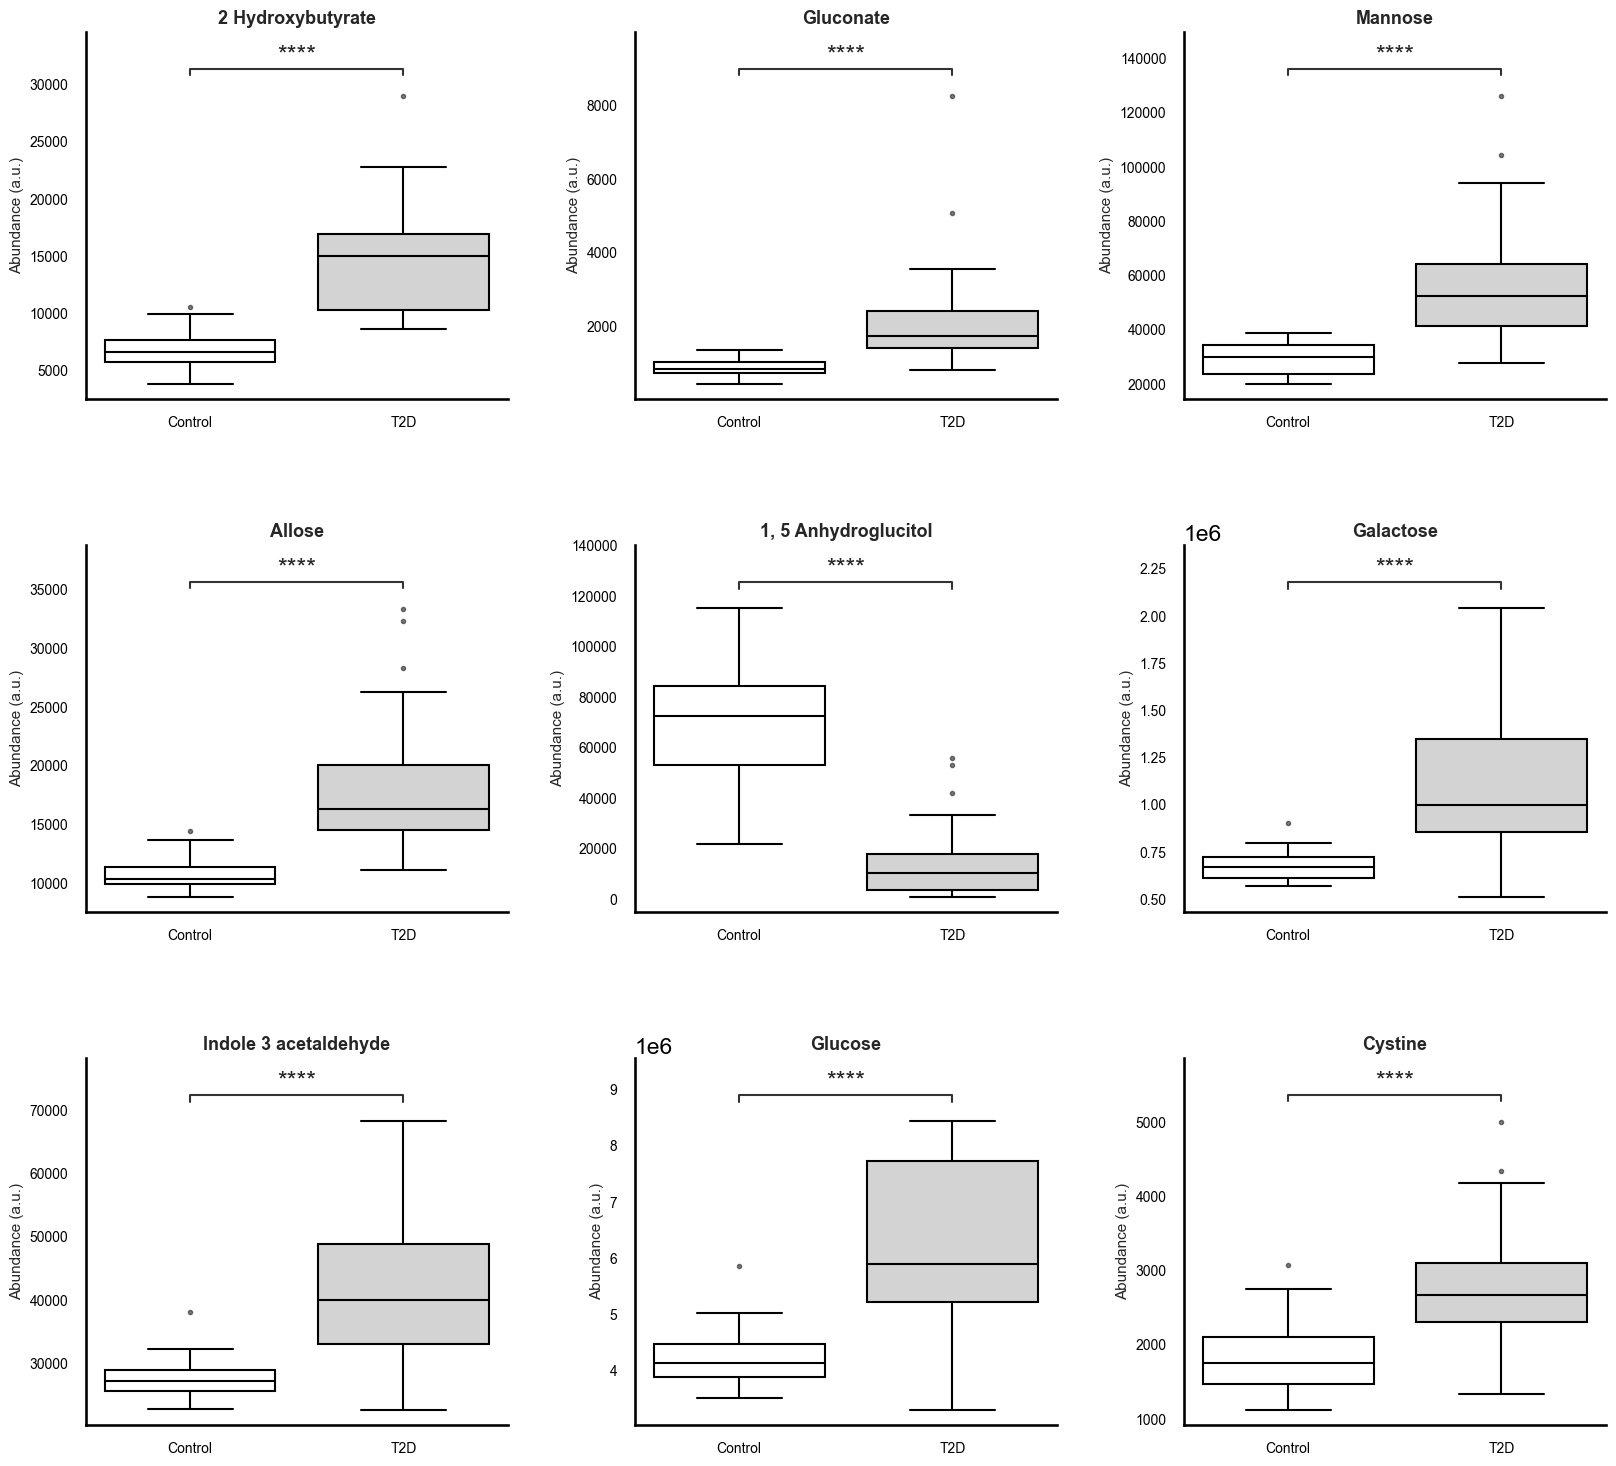

In [188]:
# Set black & white theme
sns.set_theme(
    style="white",
    context="talk",
    rc={"axes.edgecolor": "black", "xtick.color": "black", "ytick.color": "black"},
)
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False

# Define features and layout
feat_list = [
    "2-Hydroxybutyrate",
    "Gluconate",
    "Mannose",
    "Allose",
    "1,5-Anhydroglucitol",
    "Galactose",
    "Indole-3-acetaldehyde",
    "Glucose",
    "Cystine",
]
num_col = 3
num_row = math.ceil(len(feat_list) / num_col)

fig, axes = plt.subplots(num_row, num_col, figsize=(num_col * 5.5, num_row * 5))
axes = axes.flatten()

# Map class labels to readable form
df_plot["Class"] = df["Class"].map({0: "Control", 1: "T2D"})

for i, metabolite in enumerate(feat_list):
    ax = axes[i]

    # Use gray shades: white fill with black outline
    sns.boxplot(
        x="Class",
        y=metabolite,
        data=df_plot,
        ax=ax,
        palette=["white", "lightgray"],
        linewidth=1.5,
        fliersize=3,
        saturation=1,
        boxprops=dict(edgecolor="black"),
        medianprops=dict(color="black"),
        whiskerprops=dict(color="black"),
        capprops=dict(color="black"),
        flierprops=dict(
            marker="o",
            markerfacecolor="black",
            markeredgecolor="black",
            markersize=3,
            alpha=0.5,
        ),
    )

    # Set up annotation pair
    pairs = [("Control", "T2D")]

    # Annotate with stars manually using legacy method
    annotator = Annotator(ax, pairs, data=df_plot, x="Class", y=metabolite)
    annotator.set_pvalues([pvals[metabolite]])  # set p-value
    annotator.annotate()  # add the annotation

    ax.set_title(
        metabolite.replace("-", " ").replace(",", ", "), fontsize=13, weight="bold"
    )
    ax.set_ylabel("Abundance (a.u.)", fontsize=11)
    ax.set_xlabel("")
    ax.tick_params(axis="both", labelsize=10)

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.show()